In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

__PATH__ = Path().parent
__DATA__ = __PATH__ / 'db'

def load_data(ref:str='hasil hasil belajar', type:str='xlsx', sheet:int=2) -> pd.DataFrame :
    """
    
    Fungsi ini mengembalikan data yang dibutuhkan untuk tugas Fuzzy Logic (Rules)
    ref : str 
        Nama file yang akan di load | default : 'hasil hasil belajar.xlsx'
    type : str {'xlsx','csv'}
        Tipe file yang akan di load | default : 'xlsx'
    sheet : int
        Sheet yang akan di load | default : 2
    
    Output : pd.DataFrame
    
    """
    try : 
        if type == 'xlsx' : 
            output = pd.read_excel(__DATA__ / f'{ref}.xlsx', sheet_name=sheet)
        elif type == 'csv' : 
            output = pd.read_csv(__DATA__ / f'{ref}.csv', sheet_name=sheet)
        else : 
            raise ValueError(f'Tipe file {type} tidak dikenal')
    except : 
        raise FileNotFoundError(f'File {ref} tidak ditemukan')
        # print(f'File {ref} tidak ditemukan')
    
    return output
    


In [297]:
df = load_data()
df.head()

,Unnamed: 0,rata2 Lama akses materi,"lama_berlatih (min 5, mak 15)",nilai,lulus,kepercayaan
0,NaN,kecil,kecil,kecil,tidak lulus,100
1,NaN,kecil,kecil,sedang,tidak lulus,100
2,NaN,kecil,kecil,besar,tidak lulus,95
3,NaN,kecil,sedang,kecil,tidak lulus,100
4,NaN,kecil,sedang,sedang,tidak lulus,95


In [298]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [299]:
df.head()

,rata2 Lama akses materi,"lama_berlatih (min 5, mak 15)",nilai,lulus,kepercayaan
0,kecil,kecil,kecil,tidak lulus,100
1,kecil,kecil,sedang,tidak lulus,100
2,kecil,kecil,besar,tidak lulus,95
3,kecil,sedang,kecil,tidak lulus,100
4,kecil,sedang,sedang,tidak lulus,95


In [300]:
#remove whitespace
# for key,value in df.iterrows():
    # df.loc[key,'nilai'] = value['nilai'].strip()
    # print(f"**{value['nilai']}**")
print(f"**{df.loc[0,'nilai']}**")

**kecil**


In [301]:
df.columns
df.duplicated().sum()

np.int64(0)

In [302]:
#Check duplikat
df_no_kepercayaan = df.drop(columns=['kepercayaan'])
df_no_kepercayaan.duplicated().sum()
print(len(df))

27


In [303]:
for key,value in df.iterrows():
    print(key,value)

0 rata2 Lama akses materi                kecil
lama_berlatih (min 5, mak 15)          kecil
nilai                                  kecil
lulus                            tidak lulus
kepercayaan                              100
Name: 0, dtype: object
1 rata2 Lama akses materi                kecil
lama_berlatih (min 5, mak 15)          kecil
nilai                                 sedang
lulus                            tidak lulus
kepercayaan                              100
Name: 1, dtype: object
2 rata2 Lama akses materi                kecil
lama_berlatih (min 5, mak 15)          kecil
nilai                                  besar
lulus                            tidak lulus
kepercayaan                               95
Name: 2, dtype: object
3 rata2 Lama akses materi                kecil
lama_berlatih (min 5, mak 15)         sedang
nilai                                  kecil
lulus                            tidak lulus
kepercayaan                              100
Name: 3, dtype: object


In [304]:
def triangular_fuzzy(max:float, min:float, mid:float, x:float) -> float:
    """
    Fungsi ini mengembalikan nilai fuzzy dari suatu nilai x
    max : float
        Batas atas
    min : float
        Batas bawah
    mid : float
        Nilai tengah
    x : float
        Nilai x yang akan dihitung
        
    Output : float
    """
    if x <= min : 
        return 0
    elif x <= mid : 
        return (x - min) / (mid - min)
    elif x <= max : 
        return (max - x) / (max - mid)
    else : 
        return 0


def trapezoidal_fuzzy(max:float, min:float, mid1:float, mid2:float, x:float, type:str) -> float:
    """
    Fungsi ini mengembalikan nilai fuzzy dari suatu nilai x
    max : float
        Batas atas
    min : float
        Batas bawah
    mid1 : float
        Nilai tengah 1
    mid2 : float
        Nilai tengah 2
    x : float
        Nilai x yang akan dihitung
    type : str {'left','right'}
        Tipe trapesium yang akan dihitung
        
    Output : float
    """
    if type == 'left' : 
        if x <= min : 
            return 1
        elif x <= mid1 : 
            return (x - min) / (mid1 - min)
        elif x <= mid2 : 
            return 1
        elif x <= max : 
            return (max - x) / (max - mid2)
        else : 
            return 0
    elif type == 'right' : 
        if x <= min : 
            return 0
        elif x <= mid1 : 
            return (x - min) / (mid1 - min)
        elif x <= mid2 : 
            return 1
        elif x <= max : 
            return (max - x) / (max - mid2)
        else : 
            return 1
    else : 
        return 0


In [305]:
df.columns.to_list()

['rata2 Lama akses materi',
 'lama_berlatih (min 5, mak 15)',
 'nilai',
 'lulus',
 'kepercayaan']

In [306]:
class DataFuzzy:
    def __init__(self, df_name, domain_width) -> None:
        df_name = df_name or "hasil hasil belajar"
        df1 = load_data(df_name, sheet=0)
        df2 = load_data(df_name, sheet=1)
        df1['kesimpulannya'] = df1['kesimpulannya'].apply(lambda x: 0)
        df1['keyakinan'] = df1['keyakinan'].apply(lambda x: 100-x)
        self.df = pd.concat([df1,df2], ignore_index=True)
        self.df['nilai'] = self.df['nilai'].apply(lambda x: int(x))
        self.findAll()
        self.columns = self.df.columns.to_list()
        # self.makeFuzzyDomain()
        self.changeMenitToDetik_Column(['lama_berlatih (min 5, mak 15)'])
        self.rules = df
        self.domain_width = domain_width
        self.Inference()
        
        
    def findMax(self, column:str) -> float:
        return self.df[column].max()
    
    def findMin(self, column:str) -> float:
        return self.df[column].min()
    
    def findAll(self):
        self.findAllMax()
        self.findAllMin()
    
    def findAllMax(self) -> dict:
        self.AllMax = {col:self.findMax(col) for col in self.df.columns}

    def findAllMin(self) -> dict:
        self.AllMin = {col:self.findMin(col) for col in self.df.columns}
    
    def deleteColumns(self, columns:list) -> None:
        self.df.drop(columns=columns, inplace=True)
        
    @staticmethod
    def __menittoDetikconverter(x:str='7 menit, 32 detik') -> int:
        """
        Fungsi ini mengembalikan nilai detik dari suatu string waktu
        x : str
            String waktu dalam format 'menit menit, detik det
        Output : int
        """
        menit, detik = x.split(',')
        menit = int(menit.split(' ')[0])
        detik = int(detik.split(' ')[1])
        return menit*60+detik
    
    def changeMenitToDetik_Column(self, columns:list) -> None:
        for col in columns:
            self.df[col] = self.df[col].apply(lambda x: self.__menittoDetikconverter(x))
        self.findAll()
            
    @staticmethod
    def make_domain(min:int,max:int,amount:int,domain_width:float=0.05) -> list:
        """
        Fungsi make_domain digunakan untuk membuat domain fuzzy
        
        min : nilai minimum dari domain fuzzy
        max : nilai maksimum dari domain fuzzy
        amount: jumlah domain fuzzy yang akan dibuat
        domain_width : lebar domain fuzzy (default : 0.05)
        rentang yang digunakan yaitu (max-min)*domain_width
        
        """
        
        domain = [(i-int((max-min)*domain_width), i-1+(max-min)//amount+int((max-min)*domain_width)) for i in range(min,max+(max%amount)+1,int((max-min)/amount))]
        # print(domain)
        if len(domain) > amount or domain[-1][1] > max:
            domain.pop()
            domain[-1] = (domain[-1][0],int(max+(max-min)*domain_width))
        
        if len(domain) != amount:
            raise ValueError("Kesalahan dalam pembuatan domain fuzzy. Nilai yang digunakan tidak dapat dibagi rata dengan jumlah domain yang ingin dibuat")
        
        domain[1] = (min + int((max-min)*domain_width), max - int((max-min)*domain_width))
        return domain            
            
    def makeFuzzyDomain(self, exception:list=[], domain_width:float=0.05) -> None:
        self.data_fuzzy = {}
        for value in self.columns:
            if(value not in exception):
                try:
                    # if(value == 'lama_berlatih (min 5, mak 15)'):
                    #     self.data_fuzzy[value] = (self.make_domain(5*60,15*60,3))
                    # else:
                    ans = (self.make_domain(min=int(self.AllMin[value]),max=int(self.AllMax[value]),amount=3,domain_width=domain_width))
                    self.data_fuzzy[value] = ans
                    # print(ans)
                except ValueError as e:
                    # print(e)
                    self.data_fuzzy[value] = None
                
        # self.showFigure()
                
    @staticmethod
    def checkRange(data:dict, title:str, value:int) -> list[int]:
        """
        Fungsi ini mengembalikan index rentang fuzzy dari suatu nilai
        data : dict
            Data fuzzy yang akan di cek
        title : str
            Judul data yang akan di cek
        value : int
            Nilai yang akan di cek
            
        Minus : Belum bisa mencari jika dia berada di 2 rentang bersamaan
            
        Output : list[int]
        """
        ans = []
        # print(data[title][0])
        for idx, (min,max) in enumerate(data[title]):
            if (idx == 0) and (value <= min):
                ans.append(idx)
            elif (idx == len(data[title])-1) and (value >= max):
                ans.append(idx)
            elif value >= min and value <= max:
                ans.append(idx)
        return ans


    def showFigure(self) -> None:
        if self.data_fuzzy is None:
            raise ValueError("Data Fuzzy belum dibuat")
        
        if self.AllMax is None or self.AllMin is None:
            raise ValueError("Data Max atau Min belum dibuat")
        
        fig, ax = plt.subplots(1,len(self.data_fuzzy),figsize=(10,2))  
        for key,data in enumerate(self.data_fuzzy):
            for idx, (min,max) in enumerate(self.data_fuzzy[data]):
                # print(min,max)
                if idx == 0:
                    ax[key].plot([min, (max+min)/2, max], [1, 1, 0])
                elif idx == len(self.data_fuzzy[data])-1:
                    ax[key].plot([min, (max+min)/2, max], [0, 1, 1])
                else:
                    ax[key].plot([min, (max+min)/2, max], [0, 1, 0])
                
                ax[key].set_title(f'{data}', fontsize=6)
                # ax[key].set_xlabel('Nilai', fontsize=6)
                ax[key].set_ylabel('Fuzzy Value', fontsize=6)
                
    @staticmethod
    def flatten_list(list_flatten:list) -> list:
        """
        Fungsi flatten_list digunakan untuk meratakan list
        
        list_flatten : list yang akan diratakan
        
        """
        return [item for sublist in list_flatten for item in sublist]

    def Fuzzifikasi(self, exceptions:list[str]) -> dict:
        """"
        
        Fungsi ini digunakan untuk menghitung nilai fuzzy dari suatu data dan mendapatkan derajat keanggotaannya
        
        
        """
        if self.df is None:
            raise ValueError("Data belum di load")
        
        if self.data_fuzzy is None:
            raise ValueError("Data Fuzzy belum dibuat")
        
        self.hasilFuzzy = None
        all_result = []
        for key,value in self.df.iterrows():
            result = {}
            for idx, data in value.items():
                if (idx not in exceptions):
                    ans = []
                    selected = self.checkRange(self.data_fuzzy, idx, data)
                    # print(selected)
                    for num in selected:
                        # print(self.data_fuzzy[idx][0][num][1])
                        maks = self.data_fuzzy[idx][num][1]
                        minn = self.data_fuzzy[idx][num][0]
                        if num == 0: #kalo di anggota kiri (trapezoidal kiri)
                            ans.append(trapezoidal_fuzzy(min=minn, mid1=minn, mid2=(maks+minn)/2, max=maks, x=data, type='left'))
                        elif num == len(self.data_fuzzy[idx])-1: #kalo di anggota tengah (segitiga)
                            ans.append(trapezoidal_fuzzy(min=minn, mid1=(maks+minn)/2, mid2=maks, max=maks, x=data, type='right'))
                        else: #kalo di anggota kanan (trapezoidal kanan)
                            ans.append(triangular_fuzzy(min=minn, mid=(maks+minn)/2, max=maks, x=data))
                    result[idx] = selected, ans
                
            all_result.append(result)
            
        self.hasilFuzzy = all_result
        # print(len(self.hasilFuzzy))
        return all_result
    
    def showFuzzyResult(self, idx:int) -> None:
        """
        
        Fungsi ini digunakan untuk menampilkan hasil fuzzy dari suatu data
        idx : int
            Index data yang ingin ditampilkan
        
        """
        if self.hasilFuzzy is None:
            raise ValueError("Data Fuzzy belum dihitung")
        if idx >= len(self.hasilFuzzy):
            raise ValueError("Index yang diinput melebihi jumlah data")
        
        for key,value in self.hasilFuzzy[idx].items():
            print(key,value)
            
    @staticmethod
    def findCombination(data:list) -> list:
        """
        Fungsi ini mengembalikan semua kombinasi dari suatu list untuk fuzzy
        data : list
            List yang isinya list dari data yang ingin dicari
            
        Output : list
        """
        
        all_count = [0 for _ in range(len(data))]
        prob = 1
        for i in all_count:
            prob *= len(data[i])
        all_comb = []
        for _ in range(prob):
            # print(all_count)
            temp = []
            try :
                for idx,value in enumerate(all_count):
                    temp.append(data[idx][value])
                if temp not in all_comb:
                    all_comb.append(temp)
                    
                all_count[-1] += 1
                for i in range(len(all_count)-1,-1,-1):
                    if all_count[i] == len(data[i]):
                        all_count[i] = 0
                        all_count[i-1] += 1
            except:
                break                
        return all_comb
   
   
    @staticmethod
    def applyRules(data:list, rules:pd.DataFrame, value:float) -> list:
        """
        
        Fungsi ini digunakan untuk mencocokkan rules pada data fuzzy (satu data)
        data : list
            List data fuzzy yang akan di cek
        rules : pd.DataFrame
            Data rules yang akan di cek
        value : float
            Derajat keanggotaan dari data fuzzy
        
        """
        ans = []
        for key,rule in rules.iterrows():
            if(data == [rule[0], rule[1], rule[2]]): 
                ans.append((rule.iloc[-2], rule.iloc[-1]))
                break
        return ans
   
    def Process(self) -> None:
        """
        
        Fungsi ini digunakan untuk memproses data fuzzy yang sudah dihitung, dan mencari hasil inferensi
        
        """
        if self.hasilFuzzy is None:
            raise ValueError("Data Fuzzy belum dihitung")
        
        all_result = []
        for value in self.hasilFuzzy:
            result = []
            for idx, data in value.items():
                result.append(data[0])
                
            ans = self.findCombination((result))
            all_combi = []
            for search in ans:
                smallestValue = value[list(value.keys())[0]][1][value[list(value.keys())[0]][0].index(search[0])]
                for key,(idx, data) in enumerate(value.items()):
                    try:
                        smallestValue = min(smallestValue, data[1][data[0].index(search[key])])
                    except:
                        pass
                    # print(data[1][search[idx]])
                all_combi.append((search, smallestValue))
            
            all_result.append(all_combi)
            
        
        mapping = {
            0 : 'kecil',
            1 : 'sedang',
            2 : 'besar'
        }
        
        #apply rules
        inferenced_result = []
        # print(all_result[0])
        for data in all_result:
            best = []
            for combination,value in data:
                mapped_value = [mapping[value] for value in combination]
                result = self.applyRules(mapped_value, self.rules, value)
                try:
                    if best[1] < result[0][1]:
                        best = result
                except:
                    best = result
            inferenced_result.append(best)
        
        self.InferenceResult = inferenced_result
        # print(len(self.InferenceResult), len(self.hasilFuzzy))
        
        
    def showAccuracy(self, output=False) -> None:
        """
        
        Fungsi ini digunakan untuk menampilkan akurasi dari hasil inferensi
        Accuracy = (Jumlah data yang benar / Jumlah data) * 100%
        
        """
        if self.InferenceResult is None:
            raise ValueError("Data Inference belum dihitung")
        
        count = 0
        maps = {
            0 : 'tidak lulus',
            1 : 'lulus'
        }
        for key,value in enumerate(self.InferenceResult):
            real =  maps[self.df.loc[key, 'kesimpulannya']]
            if real == value[0][0]:
                count += 1
        # print(f"Accuracy : {count/len(self.InferenceResult)*100}%")
        if output:
            print(f"Accuracy : {count/len(self.InferenceResult)*100:.2f}%")
        return count/len(self.InferenceResult)*100
        
    def Inference(self, FuzzyDomain_ColumnsException:list[str]=['no','kesimpulannya','keyakinan']) -> None:
        self.makeFuzzyDomain(exception=FuzzyDomain_ColumnsException, domain_width=self.domain_width)
        self.Fuzzifikasi(exceptions=FuzzyDomain_ColumnsException)
        self.Process()
        # self.showAccuracy()
        
    def __repr__(self) -> str:
        return f"{self.AllMax}, {self.AllMin}, {self.data_fuzzy}"    
        
    @staticmethod    
    def optimization_graph(x:list,y:list):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x,y)
        # ax.set_xticks(x)
        ax.set_xlabel('Domain Range')
        ax.set_ylabel('Accuracy')
        ax.set_title('Optimization Graph')
        plt.show()
        
    def optimation(self, domain_range:list[float]):
        x,y=[],[]
        bestFit = None
        for i in tqdm(range(0,len(domain_range)), desc='Preedicting'):
        # for data in domain_range:
            self.domain_width = domain_range[i]
            self.Inference()
            x.append(domain_range[i])
            y.append(self.showAccuracy())
            if bestFit is None:
                bestFit = (domain_range[i],self.showAccuracy())
            elif bestFit[1] < self.showAccuracy():
                bestFit = (domain_range[i],self.showAccuracy())
        print(f"x : {x}, y : {y}")
        self.optimization_graph(x,y)
        self.bestFit = bestFit
        print(f"Best Fit : {bestFit}")
        

In [307]:
data_1 = DataFuzzy('hasil hasil belajar', domain_width=0.05)

C:\Users\pande\AppData\Local\Temp\ipykernel_6300\216905476.py:262: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


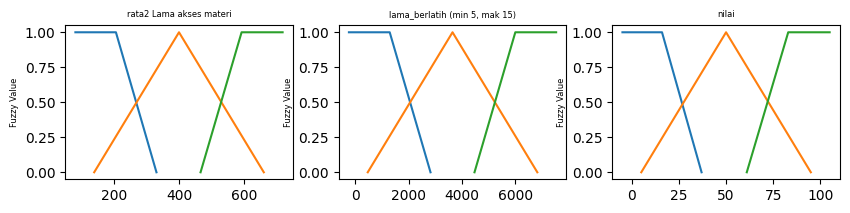

In [308]:
data_1.showFigure()

In [309]:
import numpy as np

Preedicting:   0%|          | 0/49 [00:00<?, ?it/s]C:\Users\pande\AppData\Local\Temp\ipykernel_6300\216905476.py:262: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):
Preedicting: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]

x : [np.float64(0.01), np.float64(0.02), np.float64(0.03), np.float64(0.04), np.float64(0.05), np.float64(0.060000000000000005), np.float64(0.06999999999999999), np.float64(0.08), np.float64(0.09), np.float64(0.09999999999999999), np.float64(0.11), np.float64(0.12), np.float64(0.13), np.float64(0.14), np.float64(0.15000000000000002), np.float64(0.16), np.float64(0.17), np.float64(0.18000000000000002), np.float64(0.19), np.float64(0.2), np.float64(0.21000000000000002), np.float64(0.22), np.float64(0.23), np.float64(0.24000000000000002), np.float64(0.25), np.float64(0.26), np.float64(0.27), np.float64(0.28), np.float64(0.29000000000000004), np.float64(0.3), np.float64(0.31), np.float64(0.32), np.float64(0.33), np.float64(0.34), np.float64(0.35000000000000003), np.float64(0.36000000000000004), np.float64(0.37), np.float64(0.38), np.float64(0.39), np.float64(0.4), np.float64(0.41000000000000003), np.float64(0.42000000000000004), np.float64(0.43), np.float64(0.44), np.float64(0.45), np.floa

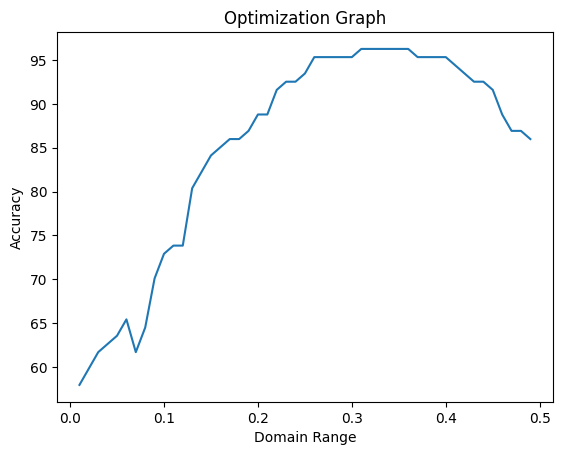

Best Fit : (np.float64(0.31), 96.26168224299066)


In [310]:
data_1.optimation(np.arange(0.01,0.5,0.01))

In [331]:
# data_1.AllMin
data_1.domain_width = 0.31
data_1.Inference()

C:\Users\pande\AppData\Local\Temp\ipykernel_6300\216905476.py:262: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


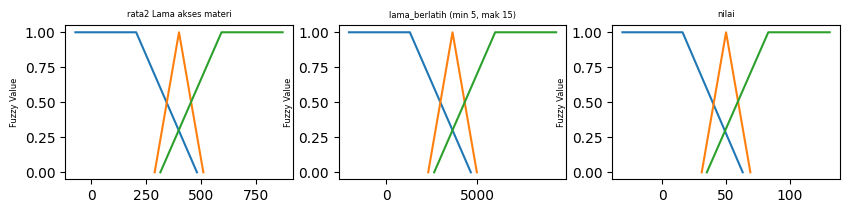

In [332]:
data_1.showFigure()

In [333]:
data_1.domain_width = 0.01
data_1.Inference()

C:\Users\pande\AppData\Local\Temp\ipykernel_6300\216905476.py:262: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


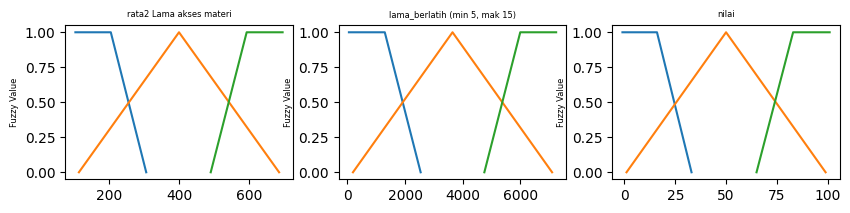

In [334]:
data_1.showFigure()

In [313]:
data_1.data_fuzzy

{'rata2 Lama akses materi': [(-175, 585), (393, 406), (211, 974)],
 'lama_berlatih (min 5, mak 15)': [(-3332, 5922), (3574, 3716), (1366, 10622)],
 'nilai': [(-49, 81), (49, 51), (17, 149)]}

In [314]:
max = 690
min = 109
domain_width = 0.5
amount = 3

print(data_1.make_domain(min,max,amount,domain_width))


[(-181, 591), (399, 400), (205, 980)]


In [315]:
data_2 = DataFuzzy('hasil hasil belajar', domain_width=0.7)

C:\Users\pande\AppData\Local\Temp\ipykernel_6300\216905476.py:262: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(data == [rule[0], rule[1], rule[2]]):


In [316]:
data_2.data_fuzzy 

{'rata2 Lama akses materi': [(-297, 707), (515, 284), (89, 1096)],
 'lama_berlatih (min 5, mak 15)': [(-4812, 7402), (5054, 2236), (-114, 12102)],
 'nilai': [(-70, 102), (70, 30), (-4, 170)]}

In [317]:
data_1.df.head()

,no,rata2 Lama akses materi,"lama_berlatih (min 5, mak 15)",nilai,kesimpulannya,keyakinan
0,7,590,452,75,0,35
1,12,521,790,77,0,22
2,1,532,1306,77,0,20
3,27,415,1679,77,0,22
4,76,596,1072,77,0,20


In [318]:
data_1.data_fuzzy

{'rata2 Lama akses materi': [(-175, 585), (393, 406), (211, 974)],
 'lama_berlatih (min 5, mak 15)': [(-3332, 5922), (3574, 3716), (1366, 10622)],
 'nilai': [(-49, 81), (49, 51), (17, 149)]}

In [319]:
print(data_1.AllMax.get('lama_berlatih (min 5, mak 15)'))

7169


In [320]:
print(data_1.AllMin.get('lama_berlatih (min 5, mak 15)'))

121


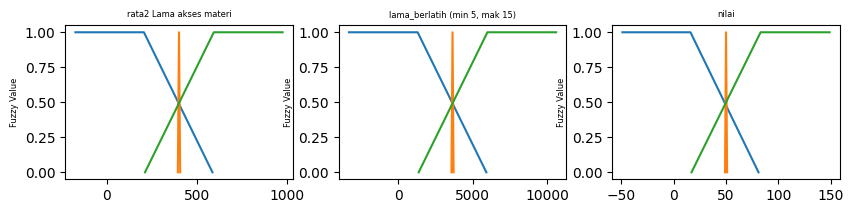

In [321]:
data_1.showFigure()

In [322]:
data_1.showAccuracy()

85.98130841121495

In [323]:
# data_1.optimation([0.1, 0.2, 0.3, 0.4, 0.5])

In [324]:
data_1

{'no': np.int64(119), 'rata2 Lama akses materi': np.int64(690), 'lama_berlatih (min 5, mak 15)': np.int64(7169), 'nilai': np.int64(100), 'kesimpulannya': np.int64(0), 'keyakinan': np.int64(100)}, {'no': np.int64(1), 'rata2 Lama akses materi': np.int64(109), 'lama_berlatih (min 5, mak 15)': np.int64(121), 'nilai': np.int64(0), 'kesimpulannya': np.int64(0), 'keyakinan': np.int64(0)}, {'rata2 Lama akses materi': [(-175, 585), (393, 406), (211, 974)], 'lama_berlatih (min 5, mak 15)': [(-3332, 5922), (3574, 3716), (1366, 10622)], 'nilai': [(-49, 81), (49, 51), (17, 149)]}